<a href="https://colab.research.google.com/github/Duder5000/Computer-Vision-Project/blob/main/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Object Detection Using YOLO <b> </h1></center>

This tutorial is designed to provide a comprehensive understanding of how to use YOLO, a state-of-the-art method in computer vision, for detecting objects in images.

Object detection and classification is a key technology in many areas, such as automated vehicles, security, and even healthcare.

We will begin with the basics of preparing (pre processing) an image dataset, ensuring it is ready for effective model training.We will then explore how YOLO, a type of convolutional neural network, automatically extracts features from images to recognize different objects. Understanding this process is crucial for grasping how YOLO operates.

The core of this tutorial is focused on transfer learning using YOLO. We will teach you how to take a pre-trained YOLO model and adapt it to a new dataset. This technique is efficient and powerful, allowing us to harness the strengths of YOLO with less computational effort.

By the end of this tutorial, you will have hands-on experience with preparing data, implementing YOLO, and understanding the principles behind it. This tutorial aims to equip students with practical skills and knowledge in one of the most exciting fields in technology.

Since its inception, the YOLO family of object detection models has come a long way. YOLOv8 is the most recent addition to this famous anchor-based single-shot family of object detectors. It comes with a bunch of improvements which include state-of-the-art accuracy and speed.  In this article, we will be fine tuning the YOLOv8 object detection model on a real-world pothole detection dataset.

In the previous lecture, you were asked to make your own custom datasets for a project you want to work on. Today we will explore how to finetune YOLO on a certain dataset.  

Importing required Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

# Dataset Description






Fruit Images for Object Detection

available on kaggle => https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection


- 240 images in train folder. 60 images in test folder.

- 3 different fruits:

    - Apple

    - Banana

    - Orange

The labels are in xml format, which is Extensible markup language.Storing image dataset labels in XML format is quite common. XML provides a clear, hierarchical structure which is ideal for representing the complex data associated with image labels. This includes not just the class of the object, but potentially a wealth of other information like bounding box coordinates, object IDs, and additional metadata.


# Data Preprocessing

For preprocessing:
- We have to convert the dataset into that acceptable by YOLO.
  - Heirarchy of folders should be the one accepted by YOLO
  - Labels format should be darknet YOLO.
  - Labels files should be .txt files
- Check and see if there are any missing labels or images. And remove them from dataset.


## Heirarchy of Folders correction

Defining paths to train and test folders.

In [3]:
test_dir = '/content/drive/MyDrive/proj/test'
train_dir = '/content/drive/MyDrive/proj/train'



The train and test folders have all the images and labels together.

But for YOLO, the directories should be in:

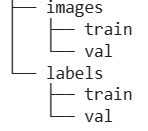


Making directories according to above struture of folders

In [4]:
#import os
#run it once for making directories

#os.makedirs('/content/drive/MyDrive/proj/Final_data')
os.makedirs('/content/drive/MyDrive/proj/Final_data/images')
os.makedirs('/content/drive/MyDrive/proj/Final_data/labels')
os.makedirs('/content/drive/MyDrive/proj/Final_data/images/train')
os.makedirs('/content/drive/MyDrive/proj/Final_data/images/val')
os.makedirs('/content/drive/MyDrive/proj/Final_data/labels/train')
os.makedirs('/content/drive/MyDrive/proj/Final_data/labels/val')

In [5]:
#set the paths to labels and images directory
label_dir= "/content/drive/MyDrive/proj/Final_data/labels"
image_dir="/content/drive/MyDrive/proj/Final_data/images"

Copy ~~XML~~ txt files and jpg files from the train folder to the folders created.

In [6]:
#import shutil
#run it once for copying!
for file in os.listdir(train_dir):
    if file.endswith(".txt"):
        shutil.copy(os.path.join(train_dir, file), os.path.join(label_dir, "train"))
    if file.endswith(".jpg"):
        image = Image.open(os.path.join(train_dir, file))
        image = image.convert("RGB")
        new_filename = os.path.splitext(file)[0] + ".jpg"
        image.save(os.path.join(image_dir,"train", new_filename), "JPEG")
        #shutil.copy(os.path.join(train_dir, file), os.path.join(image_dir, "train"))


#Copy txt files and jpg files from the test folder to the folders created.
for file in os.listdir(test_dir):
    if file.endswith(".txt"):
        shutil.copy(os.path.join(test_dir, file), os.path.join(label_dir, "val"))
    if file.endswith(".jpg"):
        image = Image.open(os.path.join(test_dir, file))
        image = image.convert("RGB")
        new_filename = os.path.splitext(file)[0] + ".jpg"
        image.save(os.path.join(image_dir,"val", new_filename), "JPEG")
        #shutil.copy(os.path.join(test_dir, file), os.path.join(image_dir, "val"))


Visualizing somme pictures from the dataset

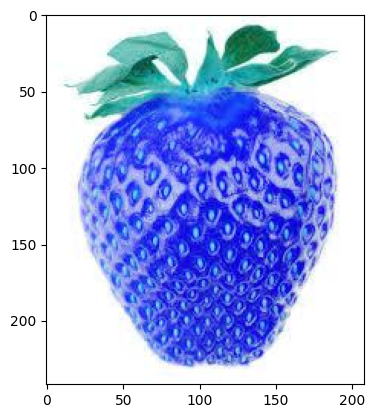

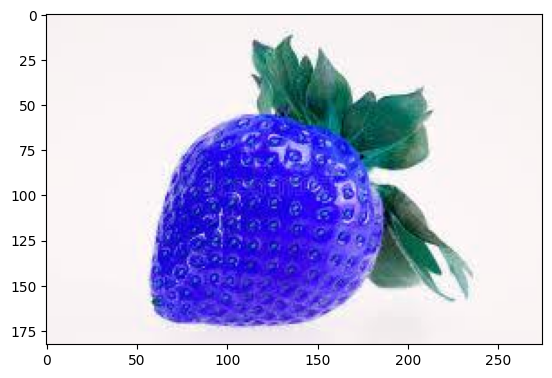

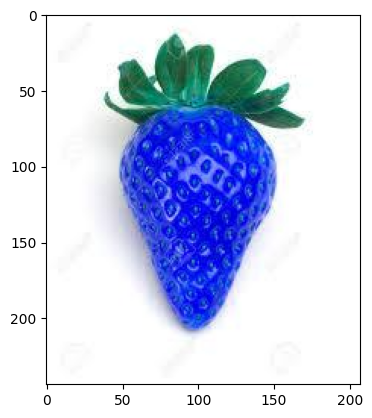

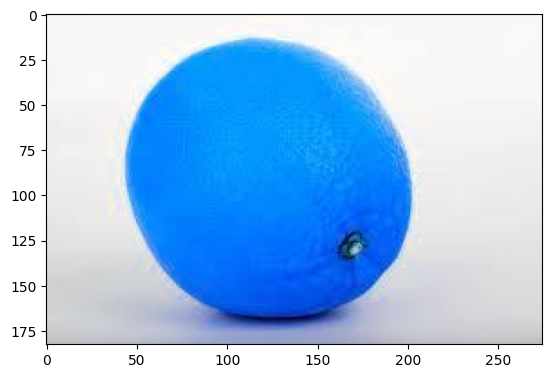

In [7]:
#visualize first four sample images from train data
for idx, image in enumerate(os.listdir(os.path.join(image_dir, "train"))):
    img = cv2.imread(os.path.join(image_dir,"train", image), 1)
    plt.imshow(img)
    plt.show()

    if idx == 3:
        break

## Creating Text files for labels
Creating Dataframes from ~~.xml~~ .txt files, from which we will eventually create .txt file for each image


In [8]:
import os
import pandas as pd

df = {'name': [],
      'label': [],
      'width': [],
      'height': [],
      'xmin': [],
      'ymin': [],
      'xmax': [],
      'ymax': []}

for file in os.listdir(train_dir):
    if file.endswith(".txt"):
        myFile = os.path.join(train_dir, file)
        with open(myFile, 'r') as file:
            firstLine = file.readline().strip()
            splitLine = firstLine.split(", ")
            print(splitLine)
            splitLineW = float(splitLine[0])
            splitLineH = float(splitLine[1])

            # Iterate through the remaining lines and print them
            for line in file:
                nextLine = line.strip()
                nextLineSplit = nextLine.split(", ")
                print(nextLineSplit)

                imgName = nextLineSplit[0]
                imgLabel = nextLineSplit[1]
                imgX1 = float(nextLineSplit[2])
                imgY1 = float(nextLineSplit[3])
                imgX2 = float(nextLineSplit[4])
                imgY2 = float(nextLineSplit[5])

                df['name'].append(imgName)
                df['label'].append(imgLabel)
                df['width'].append(splitLineW)
                df['height'].append(splitLineH)
                df['xmin'].append(imgX1)
                df['ymin'].append(imgY1)
                df['xmax'].append(imgX2)
                df['ymax'].append(imgY2)

df = pd.DataFrame(df)
display(df)

['208', '242']
['O_1', 'organic', '9.01519756838907', '6.258358662613992', '200.50455927051672', '231.79027355623103']
['275', '183']
['O_10', 'organic', '54.16666666666667', '9.798368298368302', '237.61655011655012', '172.03613053613054']
['207', '244']
['O_11', 'organic', '38.62269938650307', '15.098159509202462', '173.28527607361963', '209.26993865030673']
['275', '183']
['O_12', 'organic', '205.44871794871796', '172.502331002331', '42.278554778554785', '13.2948717948718']
['275', '183']
['O_1260', 'organic', '133.29158316633266', '30.578156312625254', '201.82865731462925', '97.7124248496994']
['O_1260', 'organic', '84.99498997995991', '103.72444889779558', '161.14729458917836', '177.07114228456913']
['O_1260', 'organic', '85.79659318637273', '164.24549098196394', '19.06312625250501', '88.6943887775551']
['O_1260', 'organic', '154.13326653306612', '167.25150300601203', '223.07114228456913', '98.1132264529058']
['O_1260', 'organic', '258.5420841683367', '70.05711422845691', '192.6102

,name,label,width,height,xmin,ymin,xmax,ymax
0,O_1,organic,208.0,242.0,9.015198,6.258359,200.504559,231.790274
1,O_10,organic,275.0,183.0,54.166667,9.798368,237.616550,172.036131
2,O_11,organic,207.0,244.0,38.622699,15.098160,173.285276,209.269939
3,O_12,organic,275.0,183.0,205.448718,172.502331,42.278555,13.294872
4,O_1260,organic,275.0,183.0,133.291583,30.578156,201.828657,97.712425
...,...,...,...,...,...,...,...,...
71,R_3804,paper,259.0,194.0,48.820594,122.053079,177.695329,154.324841
72,R_3804,paper,259.0,194.0,49.245223,151.989384,175.147558,177.042463
73,R_4471,paper,372.0,135.0,2.179775,0.758427,370.494382,133.567416
74,R_4515,paper,265.0,190.0,2.354470,2.068607,264.000000,174.563917


Doing the same for validation data labels.


In [9]:
df2 = {'name': [],
      'label': [],
      'width': [],
      'height': [],
      'xmin': [],
      'ymin': [],
      'xmax': [],
      'ymax': []}

for file in os.listdir(test_dir):
    if file.endswith(".txt"):
        myFile = os.path.join(test_dir, file)
        with open(myFile, 'r') as file:
            firstLine = file.readline().strip()
            splitLine = firstLine.split(", ")
            print(splitLine)
            splitLineW = float(splitLine[0])
            splitLineH = float(splitLine[1])

            # Iterate through the remaining lines and print them
            for line in file:
                nextLine = line.strip()
                nextLineSplit = nextLine.split(", ")
                print(nextLineSplit)

                imgName = nextLineSplit[0]
                imgLabel = nextLineSplit[1]
                imgX1 = float(nextLineSplit[2])
                imgY1 = float(nextLineSplit[3])
                imgX2 = float(nextLineSplit[4])
                imgY2 = float(nextLineSplit[5])

                df2['name'].append(imgName)
                df2['label'].append(imgLabel)
                df2['width'].append(splitLineW)
                df2['height'].append(splitLineH)
                df2['xmin'].append(imgX1)
                df2['ymin'].append(imgY1)
                df2['xmax'].append(imgX2)
                df2['ymax'].append(imgY2)

df2 = pd.DataFrame(df2)
display(df2)

['285', '177']
['O_1741', 'organic', '8.197674418604667', '59.624031007751945', '182.61627906976744', '163.3062015503876']
['O_1741', 'organic', '70.40697674418607', '19.5077519379845', '217.30620155038758', '115.82558139534883']
['O_1741', 'organic', '278.7403100775194', '13.112403100775198', '187.2674418604651', '103.61627906976744']
['O_1741', 'organic', '0.8333333333333464', '19.895348837209305', '68.27519379844964', '86.94961240310077']
['225', '225']
['O_1815', 'organic', '68.90394088669952', '53.14039408866996', '164.96305418719214', '216.6871921182266']
['O_1815', 'organic', '179.24876847290642', '67.67241379310346', '201.90886699507388', '89.34729064039409']
['O_1815', 'organic', '68.16502463054188', '76.53940886699507', '1.1699507389162704', '0.9236453201970583']
['O_1815', 'organic', '3.1403940886699644', '64.96305418719213', '75.30788177339902', '123.33743842364532']
['225', '225']
['O_21', 'organic', '200.77683615819208', '208.9689265536723', '26.76553672316384', '33.54519

,name,label,width,height,xmin,ymin,xmax,ymax
0,O_1741,organic,285.0,177.0,8.197674,59.624031,182.616279,163.306202
1,O_1741,organic,285.0,177.0,70.406977,19.507752,217.306202,115.825581
2,O_1741,organic,285.0,177.0,278.740310,13.112403,187.267442,103.616279
3,O_1741,organic,285.0,177.0,0.833333,19.895349,68.275194,86.949612
4,O_1815,organic,225.0,225.0,68.903941,53.140394,164.963054,216.687192
5,O_1815,organic,225.0,225.0,179.248768,67.672414,201.908867,89.347291
6,O_1815,organic,225.0,225.0,68.165025,76.539409,1.169951,0.923645
7,O_1815,organic,225.0,225.0,3.140394,64.963054,75.307882,123.337438
8,O_21,organic,225.0,225.0,200.776836,208.968927,26.765537,33.545198
9,O_22,organic,259.0,195.0,255.112745,159.632353,3.642157,27.769608


In [10]:
import pandas as pd
train_df = pd.DataFrame(df)
val_df=pd.DataFrame(df2)
#df1.head()
val_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax
0,O_1741,organic,285.0,177.0,8.197674,59.624031,182.616279,163.306202
1,O_1741,organic,285.0,177.0,70.406977,19.507752,217.306202,115.825581
2,O_1741,organic,285.0,177.0,278.740310,13.112403,187.267442,103.616279
3,O_1741,organic,285.0,177.0,0.833333,19.895349,68.275194,86.949612
4,O_1815,organic,225.0,225.0,68.903941,53.140394,164.963054,216.687192


![s1.png](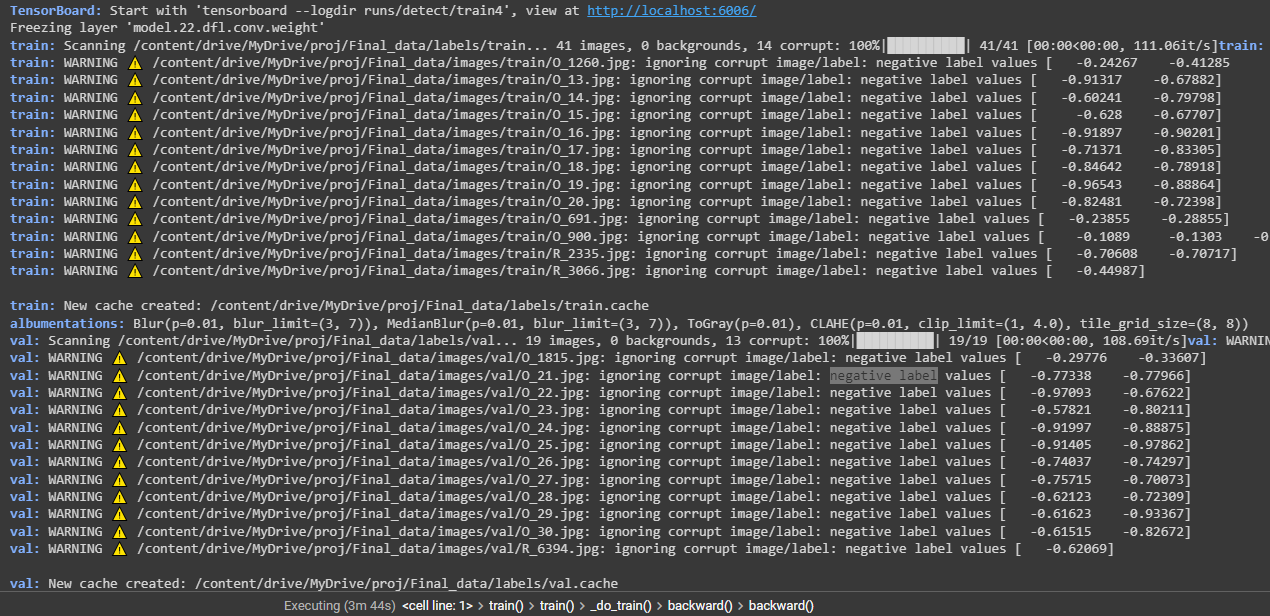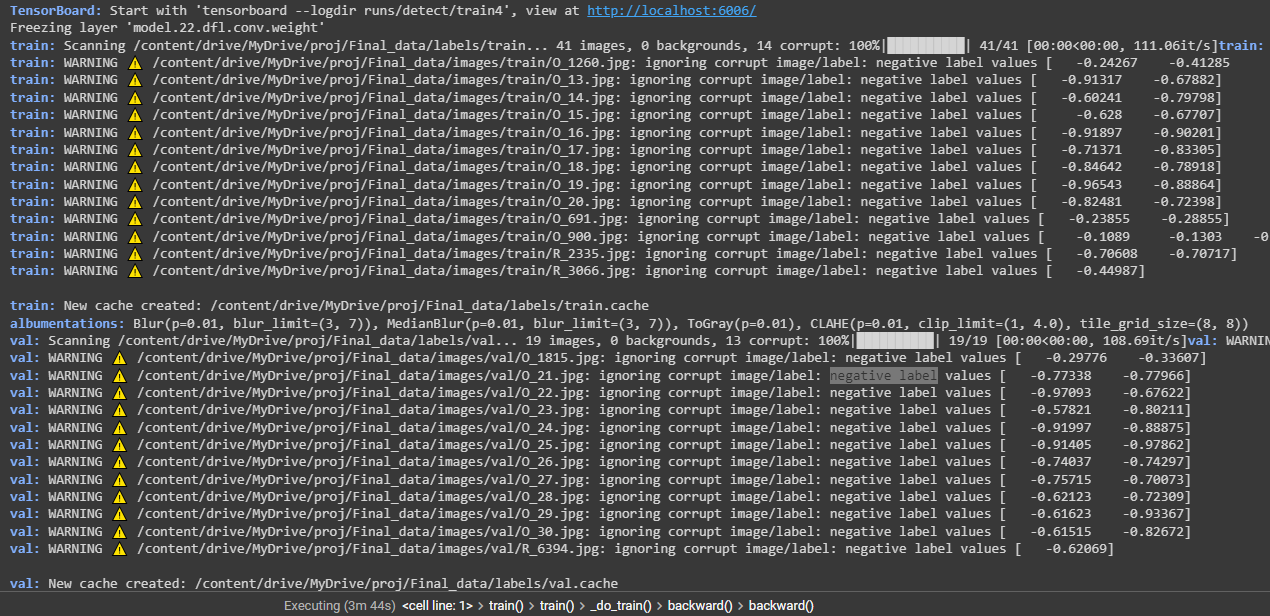)Visualizing one of the image in train set with the bounding box

error                                     Traceback (most recent call last)
<ipython-input-11-aa0595edfaac> in <cell line: 6>()
      4 image = cv2.imread(os.path.join(image_dir,"train", train_df["name"][index]+".jpg"), 1)
      5 # Draw rectangle
----> 6 cv2.rectangle(image, (train_df['xmin'][index], train_df['ymin'][index]), (train_df['xmax'][index], train_df['ymax'][index]), (255, 0, 0), 2)
      7 # Put label (class_id) near the bbox
      8 label = train_df["label"][index]

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2

In [11]:
index= 10 #picture to visualize

# #import cv2
# image = cv2.imread(os.path.join(image_dir,"train", train_df["name"][index]+".jpg"), 1)
# # Draw rectangle
# cv2.rectangle(image, (train_df['xmin'][index], train_df['ymin'][index]), (train_df['xmax'][index], train_df['ymax'][index]), (255, 0, 0), 2)
# # Put label (class_id) near the bbox
# label = train_df["label"][index]
# cv2.putText(image, str(label), (train_df['xmin'][index], train_df['ymin'][index]+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
# # Display image
# plt.imshow(image)
# plt.axis('off')
# plt.show()

Checking to see if the above image has bounding boxes around other apples or not.

In [12]:
train_df["name"][index]
filtered_df = train_df[train_df['name'] == train_df["name"][index]]
print(filtered_df)

    name    label  width  height        xmin        ymin       xmax       ymax
10  O_13  organic  235.0   215.0  226.283784  196.283784  11.689189  50.337838


Checking to see the datatypes of all the columns and if there is any null value that needs to be eliminated from the data.

In [13]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    30 non-null     object 
 1   label   30 non-null     object 
 2   width   30 non-null     float64
 3   height  30 non-null     float64
 4   xmin    30 non-null     float64
 5   ymin    30 non-null     float64
 6   xmax    30 non-null     float64
 7   ymax    30 non-null     float64
dtypes: float64(6), object(2)
memory usage: 2.0+ KB


What different types of labels are assigned to each sample and checking if they match the provided label/class information, i.e. there are no extra labels due to mistakes in spellings etc.

In [14]:
print(train_df['label'].unique())
print(val_df['label'].unique())

['organic' 'cardboard' 'paper']
['organic' 'cardboard' 'paper']


We need to map labels to class_ids required for YOLO

In [15]:
label_map = { 'organic': 0,
            'cardboard': 1,
            'paper': 2}

train_df['class'] = train_df['label'].map(label_map)
val_df['class'] = val_df['label'].map(label_map)

In [16]:
train_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class
0,O_1,organic,208.0,242.0,9.015198,6.258359,200.504559,231.790274,0
1,O_10,organic,275.0,183.0,54.166667,9.798368,237.616550,172.036131,0
2,O_11,organic,207.0,244.0,38.622699,15.098160,173.285276,209.269939,0
3,O_12,organic,275.0,183.0,205.448718,172.502331,42.278555,13.294872,0
4,O_1260,organic,275.0,183.0,133.291583,30.578156,201.828657,97.712425,0


convertig the bounding box format to the one required by YOLO:




In [17]:
# Training data
train_df['x_center'] = (train_df['xmin']+train_df['xmax'])/(2*train_df["width"])
train_df['y_center'] = (train_df['ymin']+train_df['ymax'])/(2*train_df["height"])
train_df['box_width'] = (train_df['xmax']-train_df['xmin'])/ train_df["width"]
train_df['box_height'] = (train_df['ymax']-train_df['ymin'])/train_df["height"]

#Validation data
val_df['x_center'] = (val_df['xmin']+val_df['xmax'])/(2*val_df["width"])
val_df['y_center'] = (val_df['ymin']+val_df['ymax'])/(2*val_df["height"])
val_df['box_width'] = (val_df['xmax']-val_df['xmin'])/ val_df["width"]
val_df['box_height'] = (val_df['ymax']-val_df['ymin'])/val_df["height"]

In [18]:
train_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_width,box_height
0,O_1,organic,208.0,242.0,9.015198,6.258359,200.504559,231.790274,0,0.503653,0.491836,0.920622,0.931950
1,O_10,organic,275.0,183.0,54.166667,9.798368,237.616550,172.036131,0,0.530515,0.496816,0.667090,0.886545
2,O_11,organic,207.0,244.0,38.622699,15.098160,173.285276,209.269939,0,0.511855,0.459771,0.650544,0.795786
3,O_12,organic,275.0,183.0,205.448718,172.502331,42.278555,13.294872,0,0.450413,0.507643,-0.593346,-0.869986
4,O_1260,organic,275.0,183.0,133.291583,30.578156,201.828657,97.712425,0,0.609310,0.350521,0.249226,0.366854


Deleting all the sample with Nan values in training and validation data

In [19]:
#training
print("before deleting (train data): " , train_df.shape)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("after deleting(train_data): " ,train_df.shape)

#validation
print("before deleting (val data): " , val_df.shape)
val_df.replace([np.inf, -np.inf], np.nan, inplace=True)
val_df.dropna(inplace=True)
print("after deleting(val data): " , val_df.shape)



before deleting (train data):  (76, 13)
after deleting(train_data):  (76, 13)
before deleting (val data):  (30, 13)
after deleting(val data):  (30, 13)


converting the dataframe to type *str* (string) to be stored in text files.

In [20]:
train_df = train_df.astype(str)
val_df = val_df.astype(str)

If there are more than one bounding boxes in single image, they should be written in one text file. As, you can see in the below example that one image has so many bounding boxes.

In [21]:
filtered_df = train_df[train_df['name'] == train_df["name"][17]]
(filtered_df.head(15))

,name,label,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_width,box_height
17,O_19,organic,247.0,204.0,244.9102564102564,190.84615384615387,6.448717948717942,9.564102564102567,0,0.5088238347347659,0.49120160884866776,-0.9654313298037994,-0.8886375062845652


In [22]:
#file_name = [x.split('.')[0] for x in df1["name"]]

#TRAINING DATA
#finding all the unique names:
unique_names= train_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = train_df[train_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/train/{name}.txt', 'w') as file:
            file.write(text)
#############################################################################################
#VALIDATION DATA
#finding all the unique names:
unique_names= val_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = val_df[val_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/val/{name}.txt', 'w') as file:
            file.write(text)

## Checking Missing Files

Checking the folders if every image file has a corresponding label file


(We will copy the code, we already used in previous turorial after updating)

In [23]:
#The lists of all the images and labels for train and validation set:
train_images=glob.glob(os.path.join(image_dir, "train",'*.jpg'))
train_labels=glob.glob(os.path.join(label_dir, "train",'*.txt'))
val_images=glob.glob(os.path.join(image_dir, "val",'*.jpg'))
val_labels=glob.glob(os.path.join(label_dir, "val",'*.txt'))
#print(val_labels)

# Get the list of filenames without extensions
image_files_train = {file.split("/")[-1].split(".")[0] for file in train_images}
label_files_train = {file.split("/")[-1].split(".")[0] for file in train_labels}

image_files_val = {file.split("/")[-1].split(".")[0] for file in val_images}
label_files_val = {file.split("/")[-1].split(".")[0] for file in val_labels}
#print(image_files_val)



In [24]:
print(len(image_files_val), "  =  ", len(label_files_val))

19   =   19


In [25]:
# Find extra files in each folder

#TRAINING DATA
extra_images_train = image_files_train - label_files_train
extra_labels_train = label_files_train - image_files_train

# Output the results
print(f"Training Extra images (without corresponding labels): {extra_images_train}")
print(f"Training Extra labels (without corresponding images): {extra_labels_train}")


#VALIDATION DATA
extra_images_val = image_files_val - label_files_val
extra_labels_val = label_files_val - image_files_val

# Output the results
print(f"Validation Extra images (without corresponding labels): {extra_images_val}")
print(f"Validation Extra labels (without corresponding images): {extra_labels_val}")

Training Extra images (without corresponding labels): set()
Training Extra labels (without corresponding images): set()
Validation Extra images (without corresponding labels): set()
Validation Extra labels (without corresponding images): set()


Make sure that the above info is correct by chceking the data manually.

Now removing from the dataset:

In [26]:
for file in extra_images_train:
     os.remove(os.path.join(image_dir, "train", file + '.jpg')) # or '.png' depending on your image format

for file in extra_images_val:
     os.remove(os.path.join(image_dir, "val", file + '.jpg'))

Now run the above cells again to find if all the missing data is deleted.

# Custom object detection using YOLO

First install and import

In [27]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.4/201.2 GB disk)


In [28]:
from ultralytics import YOLO

## Training YOLO

We are going to select small pretrained (on COCO dataset) model of YOLOv8

In [29]:
model = YOLO('yolov8s.pt') # pretrained model

100%|██████████| 21.5M/21.5M [00:00<00:00, 230MB/s]


The detailed architecture of the model can be seen from:


In [30]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [31]:
!pip install ultralytics

import ultralytics
from ultralytics import YOLO

In [32]:
%%writefile config.yaml
path: /content/drive/MyDrive/proj/Final_data
train: /content/drive/MyDrive/proj/Final_data/images/train
#test: (test dataset folder path)
val: /content/drive/MyDrive/proj/Final_data/images/val

# Classes
nc: 3 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names:
  0: organic
  1: cardboard
  2: paper

Writing config.yaml


Please look at [Yolo train Docs](https://docs.ultralytics.com/modes/train/#train-settings) for hyperparameters for model tuning and configuration, e.g. lr0, imgsz, model etc. <br/> **Warnings Screenshot below**
![](https://duder5000.com/downloads/s1.png)

In [33]:
model.train(data="config.yaml",epochs=5,patience=5,batch=8, lr0=0.0005,imgsz=640)

Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=config.yaml, epochs=5, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

100%|██████████| 755k/755k [00:00<00:00, 46.1MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

 22        [15, 18, 21]  1   2117209  ultralytics.nn.modules.head.Detect           [3, [128, 256, 512]]          
Model summary: 225 layers, 11136761 parameters, 11136745 gradients, 28.7 GFLOPs

Transferred 349/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/detect/train', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 181MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/proj/Final_data/labels/train... 41 images, 0 backgrounds, 14 corrupt: 100%|██████████| 41/41 [00:00<00:00, 142.93it/s]

train: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/train/O_12.jpg: ignoring corrupt image/label: negative label values [   -0.59335    -0.86999]
train: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/train/O_1260.jpg: ignoring corrupt image/label: negative label values [   -0.24267    -0.41285     -0.3778    -0.23975]
train: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/train/O_13.jpg: ignoring corrupt image/label: negative label values [   -0.91317    -0.67882]
train: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/train/O_14.jpg: ignoring corrupt image/label: negative label values [   -0.60241    -0.79798]
train: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/train/O_15.jpg: ignoring corrupt image/label: negative label values [     -0.628    -0.67707]
train: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/train/O_16.jpg: ignoring corrupt image/label: negative label values [   -0.91897    -0.90201]
train: WARNING ⚠️ /content

train: New cache created: /content/drive/MyDrive/proj/Final_data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/proj/Final_data/labels/val... 19 images, 0 backgrounds, 13 corrupt: 100%|██████████| 19/19 [00:00<00:00, 78.53it/s]

val: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/val/O_1741.jpg: ignoring corrupt image/label: negative label values [   -0.32096]
val: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/val/O_1815.jpg: ignoring corrupt image/label: negative label values [   -0.29776    -0.33607]
val: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/val/O_21.jpg: ignoring corrupt image/label: negative label values [   -0.77338    -0.77966]
val: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/val/O_22.jpg: ignoring corrupt image/label: negative label values [   -0.97093    -0.67622]
val: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/val/O_23.jpg: ignoring corrupt image/label: negative label values [   -0.57821    -0.80211]
val: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/val/O_24.jpg: ignoring corrupt image/label: negative label values [   -0.91997    -0.88875]
val: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/val/O_25.jpg: ignoring

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       2.4G      1.276      3.925      1.652          8        640: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all          6         10     0.0222      0.722     0.0461     0.0342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.43G      1.353      3.946      1.796         10        640: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]

                   all          6         10      0.121      0.167      0.146      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.52G      1.105      2.952      1.646          8        640: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all          6         10      0.493      0.611      0.611      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.52G      1.008      2.235       1.56         10        640: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]

                   all          6         10       0.59      0.611      0.703      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.52G     0.8507      1.809      1.435          9        640: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]

                   all          6         10      0.416      0.722      0.524      0.397



5 epochs completed in 0.005 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


                   all          6         10      0.592      0.611      0.703      0.542
               organic          6          1       0.83          1      0.995      0.796
             cardboard          6          3      0.388      0.667      0.806      0.593
                 paper          6          6      0.558      0.167      0.309      0.237
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b74e7f7d900>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Evaluation Metrics

[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.

<br/> **Warnings Screenshot below**
![](https://duder5000.com/downloads/s2.png)


In [34]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/drive/MyDrive/proj/Final_data/labels/val.cache... 19 images, 0 backgrounds, 13 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/val/O_1741.jpg: ignoring corrupt image/label: negative label values [   -0.32096]
val: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/val/O_1815.jpg: ignoring corrupt image/label: negative label values [   -0.29776    -0.33607]
val: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/val/O_21.jpg: ignoring corrupt image/label: negative label values [   -0.77338    -0.77966]
val: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/val/O_22.jpg: ignoring corrupt image/label: negative label values [   -0.97093    -0.67622]
val: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/val/O_23.jpg: ignoring corrupt image/label: negative label values [   -0.57821    -0.80211]
val: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/val/O_24.jpg: ignoring corrupt image/label: negative label values [   -0.91997    -0.88875]
val: WARNING ⚠️ /content/drive/MyDrive/proj/Final_data/images/val/O_25.jpg: ignoring


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


                   all          6         10      0.589      0.611      0.703      0.542
               organic          6          1      0.826          1      0.995      0.796
             cardboard          6          3      0.387      0.667      0.806      0.593
                 paper          6          6      0.555      0.167      0.309      0.237
Speed: 0.3ms preprocess, 34.4ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to runs/detect/train2


0.611111111111111

Showing confusion matrix, that is already stored in detect/train folder

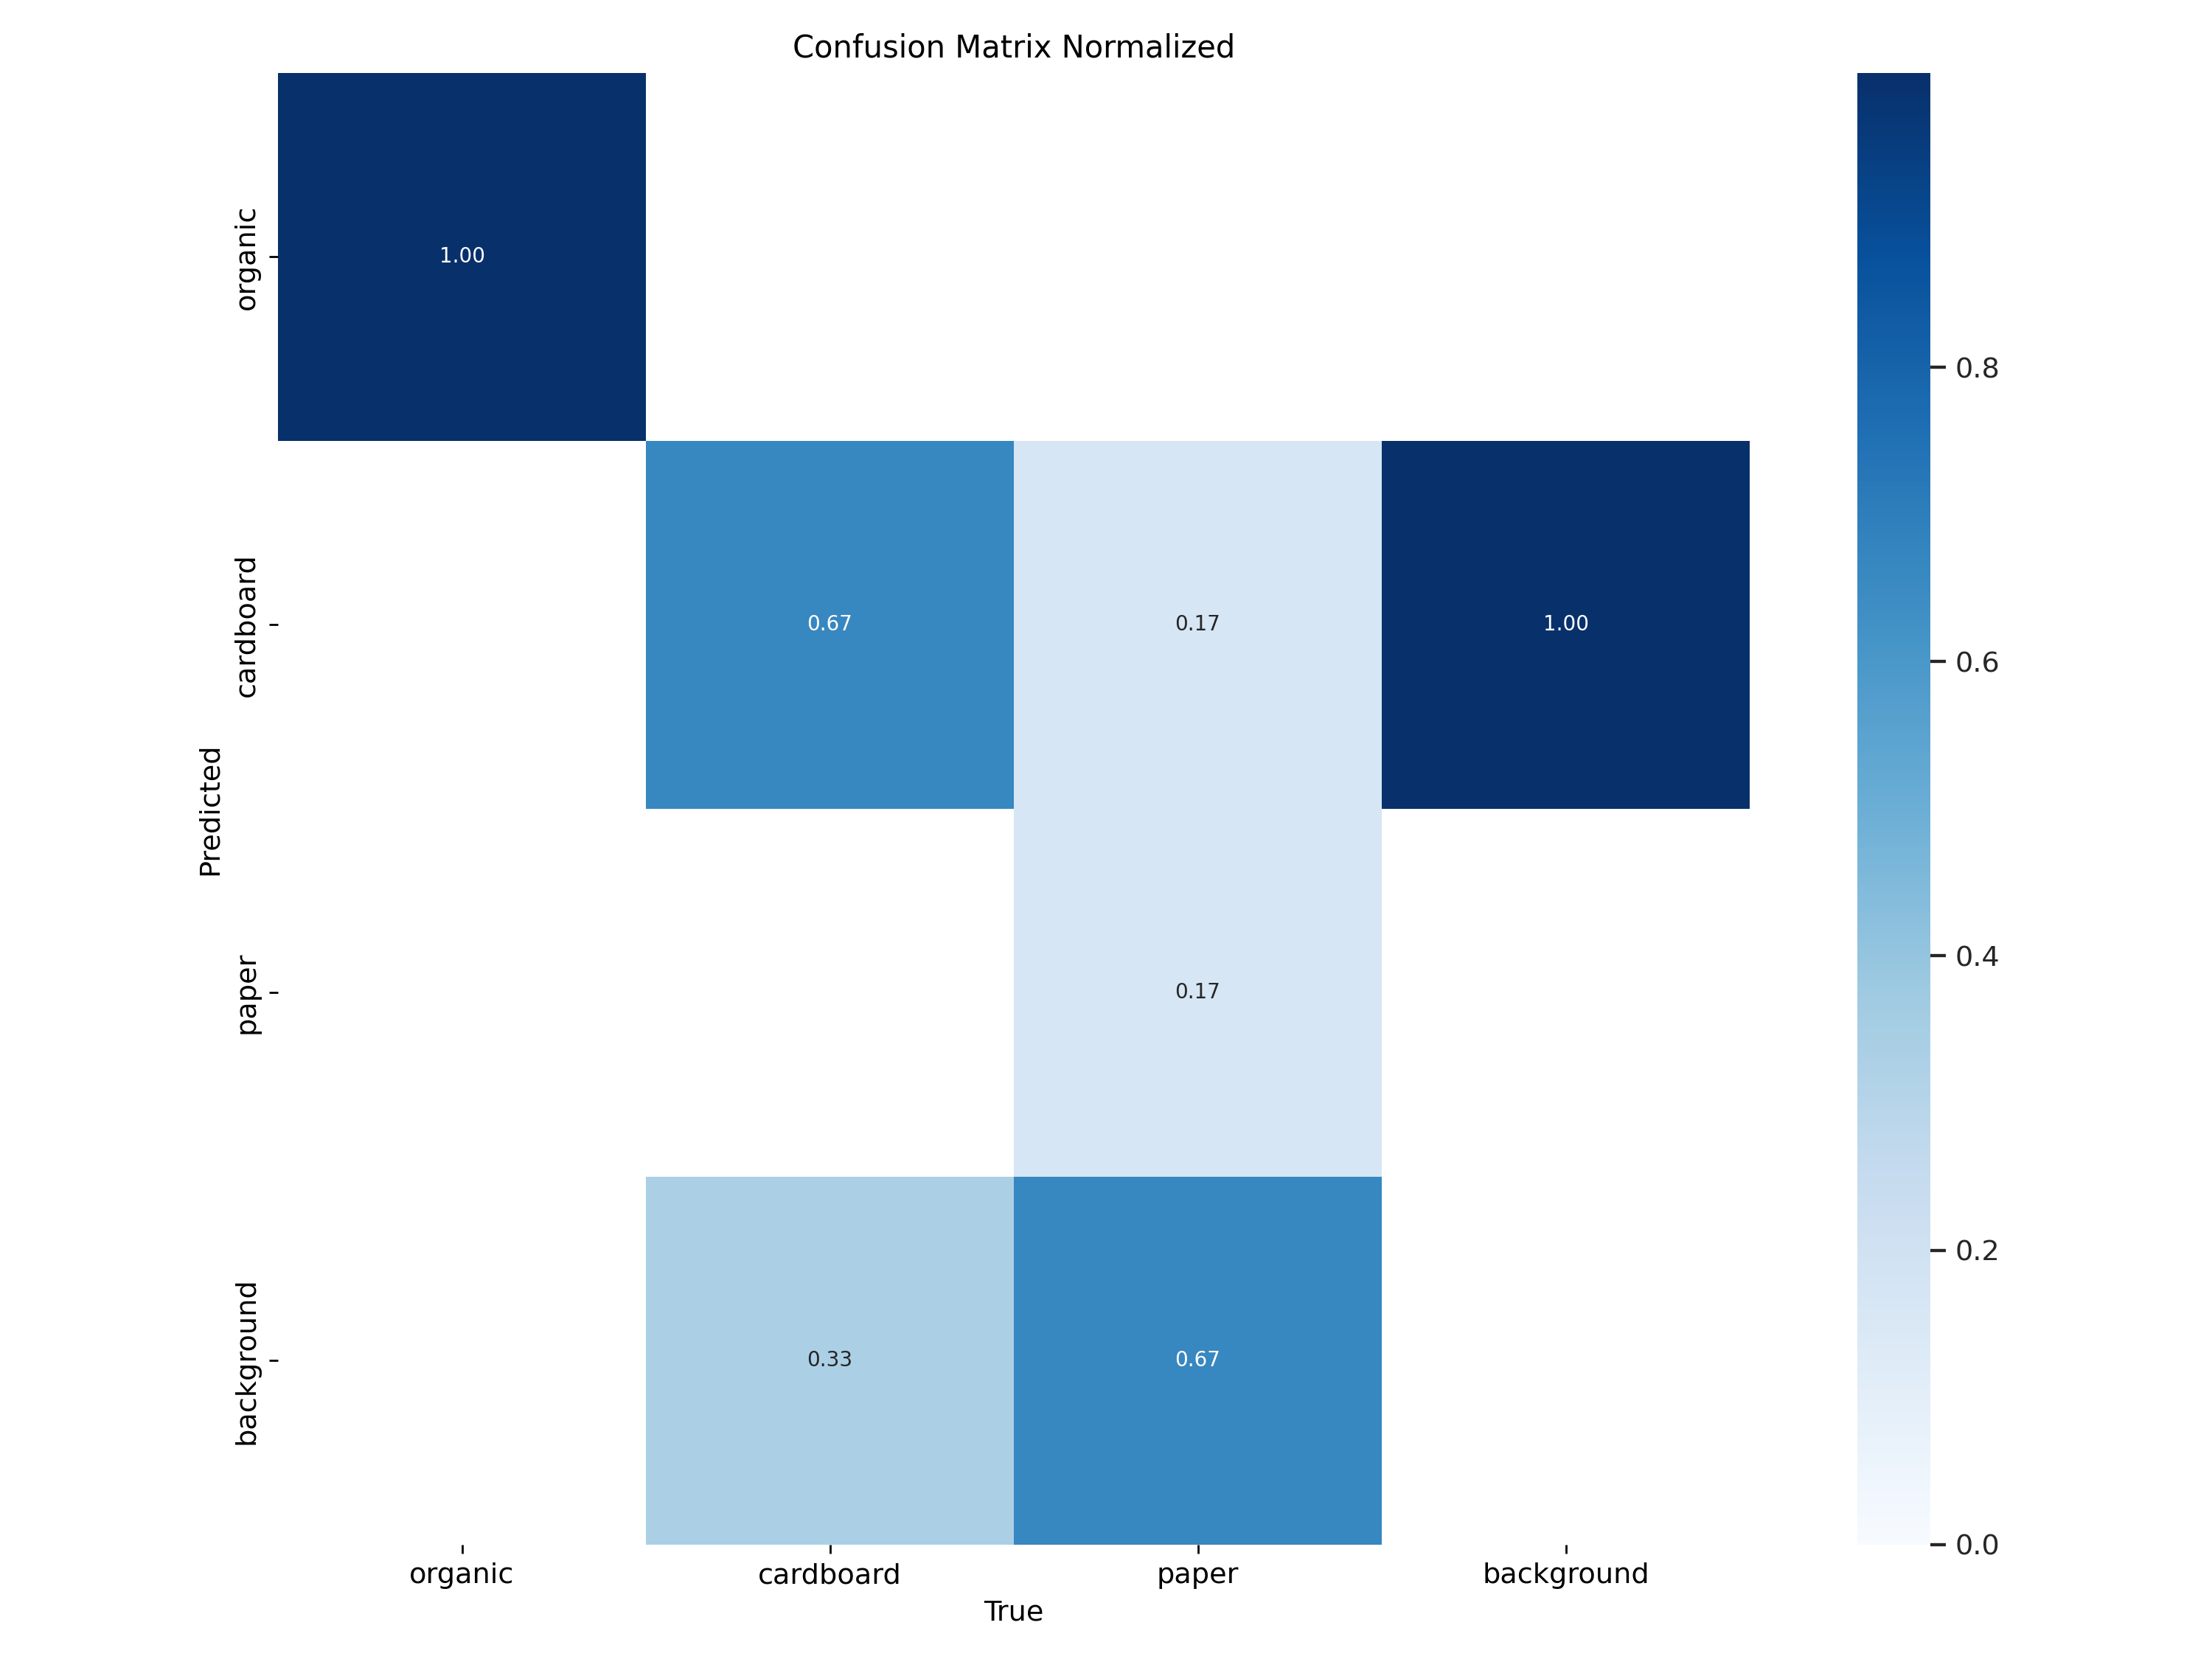

In [35]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/train/confusion_matrix_normalized.png')

##Prediction

In [36]:
model = YOLO('yolov8x.pt')  # load a custom model

# Predict with the model with any image from internet?
results = model('https://www.freshpoint.com/wp-content/uploads/2019/08/freshpoint-produce-101-apples-bananas.jpg', save=True)

100%|██████████| 131M/131M [00:00<00:00, 300MB/s]


100%|██████████| 126k/126k [00:00<00:00, 369kB/s] 


image 1/1 /content/freshpoint-produce-101-apples-bananas.jpg: 576x640 1 banana, 2 apples, 117.1ms
Speed: 1.8ms preprocess, 117.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)
Results saved to runs/detect/predict


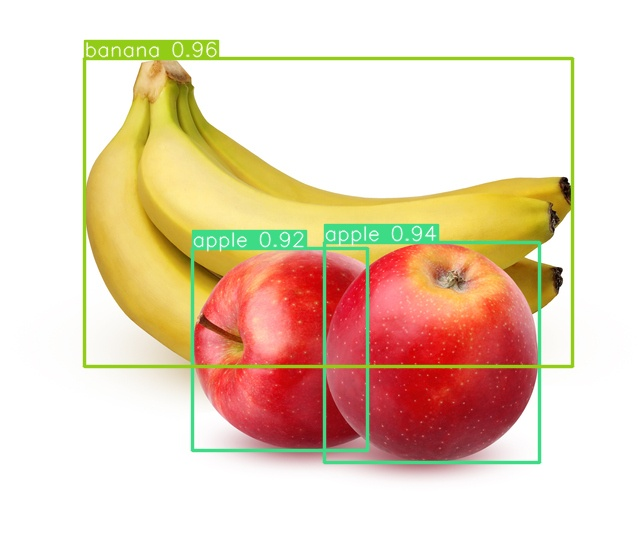

In [37]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/predict/freshpoint-produce-101-apples-bananas.jpg')